**Let's check the files we have on the machine?**

In [ ]:
%ls

**The scripts are organized in a linear workflow, designed as 'steps':**<p>
The **DB1_NCBI_download_refs.sh** script **downloads** the target reference sequences from NCBI using the **Entrez Direct** tools,<p>
The **DB2_primers_cut.sh** script **cuts** your downloaded reference sequences according to your **project's primers** used to amplify the eDNA,<p>
The **DB3_NCBI_lineage.sh** script performs the **taxonomy lineage formatting**, changing the regular NCBI sequences headers to a **parsible lineage header**,<p>
The **1_merge_pear.sh** script executes the **merging** of the original Illumina **paired-end fastq R1 and R2 files** using **PEAR** tool,<p>
The **2a_preparing_tags_LCPI.pl** script **formats** the mapping file according to **Cutadapt** input format, for the demultiplexing step,<p>
The **2b_demulti_dual_index_linked.sh** script executes the **demultiplexing** step, usign the **Cutapadt** tool to parse the sequences according to the **tags design**, atributing each sequence to a **specific sample**,<p>
The **3_tag_primer_clipping_clean_derep.sh** script run all the **data cleaning** process, **trimming** and **converting** the sequences to a **fasta** format without **PCR duplicates**, containing the actual **amplicon abundance** information,<p>
The **4_clustering_swarm_with_chim_filter.sh** script executes the **clustering** of the amplicons using the **SWARM** tool,<p>
The **5_BLAST_options.sh** script runs **BLAST** using the formatted **custom** reference database, generating a **tabular BLAST output**, plus the BLAST input for building the **OTU table** and the **taxonomy assignment table**, formatted as input to the **Data Analysis - R session**<p>
The **6a_build_OTU_table.sh** runs the **6a_OTU_contingency_table.py** script, which parses several clustering and data cleaning outputs to build the final **OTU table**,<p>
The **6b_filter_OTU_table.sh** script **formats** the OTU_table, **extracting** desired columns/informations and **converting** them to R package **Phyloseq** input format, which will be loaded in the **Data Analysis - R session**.<p>
**We also have some pre-formatted files prepared to run some of the scripts, because using a random subsample tiny enough to run fast here, we would not have enough data to analyze. The following files are pre-formatted:**<p>
**`Streptophyta_trnL_NCBI.fasta`** --> a complete reference dataset for trnL.<p>
**`target_trnL.uniq.fasta`** --> the complete and formatted reference trnL dataset.<p>
**`trnL_subsample.assembled.fastq`** --> a non-random subsample with pairs already merged.


**Let's make all the scripts executable**

In [ ]:
!chmod 777 -R *.sh *.py *.pl

Let's start running the **`DB1_NCBI_download_refs.sh`** script. Typing **`-h`** we can check how it is used:

In [ ]:
!bash DB1_NCBI_download_refs.sh -h

In order to download the trnL marker sequences for of all Streptophyta taxa, the command would be<p>
**`./DB1_NCBI_download_refs.sh -n Streptophyta -t txid35493 -m trnL`**<p>
However, this command takes to long, thus its resulting file has already been made available: **Streptophyta_trnL_NCBI.fasta**, as well as the resulting file from the taxonomy lineage editing: **target_trnL.uniq.fasta**.<p>
Let's run an example to practice this command. Run the following:<p>

In [ ]:
%%bash
./DB1_NCBI_download_refs.sh -n 'Prunus' -t txid3754 -m trnL

In [ ]:
%ls -lht | head

We have downloaded the **NCBI rbcL marker** sequences from **Peach**, let's take a look in the **first sequence**, and count the **number of sequences** downloaded:

In [ ]:
!head -2 'Prunus_trnL_NCBI.fasta'

In [ ]:
!grep -c "^>" 'Prunus_trnL_NCBI.fasta'

If you search for **`"Paeonia suffruticosa"+"trnL"`** in the nucleotide database using the NCBI web site https://www.ncbi.nlm.nih.gov/, you will see less or more entries. However, in `DB1_NCBI_download_refs.sh` script, the amplicons sequences are downloaded, excluding larger or general sequences, like "chloroplast, complete genome" genbank sequences, what makes it different from the browser search sometimes.

After downloading the sequences file, we will **cut the sequences** according to our **project's primers**, in order to **refine** our reference database with our **target sequence**, and speed up our taxa assignment process:

In [ ]:
!bash DB2_primers_cut.sh -h

**Now we are going to run with the complete `Streptophyta_trnL_NCBI.fasta` fasta file:**

In [ ]:
%%bash
./DB2_primers_cut.sh \
    -r Prunus_trnL_NCBI.fasta \
    -F GGGCAATCCTGAGCCAA \
    -R CCATTGAGTCTCTGCACCTATC \
    -p Prunus_trnL

In [ ]:
%ls -t | head

**Let's check how this data looks like? The sequences were cutted according with our primers.**

In [ ]:
!head -n 4 Prunus_trnL_cutted_references.fasta

**Let's begin to format our sequences to properly create a local BLAST database**

In [ ]:
!bash DB3_NCBI_lineage.sh -h

**This script does a lot of things:**<p>
**1.** extract **accession** code from NCBI references, then<p>
**2.** parse **accession to taxid**, then<p>
**3.** parse **taxid to lineage**, then<p>
**4.** remove NCBI sequences header, and **join edited lineage**, then<p>
**5.** remove sequence **duplicates**.<p>

To run this script we need to **download** the **`nucl_gb.accession2taxid.gz`** file:

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/accession2taxid/nucl_gb.accession2taxid.gz

**This command takes a while, even with a little reference database.**

In [ ]:
%%bash
./DB3_NCBI_lineage.sh -r Prunus_trnL_cutted_references.fasta -p Prunus_trnL

Let's take a look in the **.log** file:

In [ ]:
!tail Prunus_trnL.log

Then take a look in the **final formatted reference database**:

In [ ]:
!head Prunus_trnL.uniq.fasta

All this process can be done using **BOLD** database as well, let's try with a tiny database:

Let's run a search and download using **BOLD database**:

In [21]:
!bash BOLD_download_refs.sh -h

##################################################
 
DOWNLOAD BOLD SEQUENCES
 
Usage: BOLD_download_refs.sh [-t taxon] [-m marker] [-g geo]
-t     target taxon, e.g. Arthropoda
-m     marker, e.g. COI
-g     geographic location, e.g. Brazil
-h     print this help
More Details: http://boldsystems.org/index.php/resources/api?type=webservices#sequenceParameters
 
##################################################


In [22]:
%%bash
./BOLD_download_refs.sh -t Blattodea -m COI -g Brazil

searching and downloading:
TAXON=Blattodea
MARKER=COI
GEO=Brazil


--2021-12-13 21:11:40--  http://v3.boldsystems.org/index.php/API_Public/combined?taxon=Blattodea&marker=COI&geo=Brazil&format=tsv
Resolving v3.boldsystems.org (v3.boldsystems.org)... 131.104.63.48
Connecting to v3.boldsystems.org (v3.boldsystems.org)|131.104.63.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-download]
Saving to: ‘BOLD_Blattodea_COI_Brazil.tsv’

     0K .......... .......... .......... .......... ..........  257K
    50K .......... .......... .......... .......... ..........  833K
   100K .......... .......... .......... .......... .......... 1.59M
   150K .......... .......... .......... ........               918K=0.3s

2021-12-13 21:11:42 (576 KB/s) - ‘BOLD_Blattodea_COI_Brazil.tsv’ saved [193083]



Take a look in the **BOLD** sequences format:

In [24]:
!head -2 BOLD_Blattodea_COI_Brazil.tsv

image_ids	image_urls	copyright_licenses	trace_ids	trace_links	run_dates	sequencing_centers	directions	seq_primers	marker_codesder_taxID	order_name	family_taxID	family_name	subfamily_taxID	subfamily_name	genus_taxID	genus_name	species_taxID	species_name	subspecies_taxID	subspecies_name	identification_provided_by	voucher_type	tissue_type	collectors	collectiondate	lifestage	sex	reproduction	extrainfo	notes	lat	lon	coord_source	coord_accuracy	country	province	region	exactsite	sequenceID	markercode	genbank_accession	nucleotides	
									-19	KX036772	10157255	UFRGS 60007	 	Mined from GenBank, NCBI	BOLD:ADJ6748	20	Arthropoda	82	Insecta	532349	Blattodea	1349	Termitidae	354381	Nasutitermitinae	4335	Nasutitermes	790969	Nasutitermes jaraguae	 	 	 	 	 	 	2013-12-04	 	 	 	 	 	-23.78	-46.01	 	 	Brazil	 	 	 	11754456	COI-5P	KX036772	ATAAAGATATTGGAACTTTATATTTTGTATTTGGAGCTTGATCAGGAATAGTCGGAACATCTTTAAGAATGCTCATTCGAACAGAACTAGGACAGCCAGGATCCCTAATTGGAGACGATCAAATCTACAACGTCATTGTCACAGCCCACGCTTTTGTTATAATTTTCTT

Pretty different from **NCBI**, right?<p>
But the following script generate exactly the same output from the **primers_cut.sh** and **NCBI_lineage.sh** scripts:

In [26]:
%%bash
./BOLD_lineage_primers_cut.sh BOLD_Blattodea_COI_Brazil.tsv GCHCCHGAYATRGCHTTYCC TCDGGRTGNCCRAARAAYCA

Take a look in the final **BOLD** formated sequences:

In [28]:
!head -4 BOLD_Blattodea_COI_Brazil_cut.fasta

>GBMH10392-19/BOLD:ADJ6748 Arthropoda|Insecta|Blattodea|Termitidae|Nasutitermitinae|Nasutitermes|Nasutitermes jaraguae|
ACGAATAAACAACATAAGATTCTGGCTACTCCCTCCCTCCCTAACTCTTCTTCTTACTAGTAGTACGGTAGAAAGCGGGGTAGGAACAGGATGAACTGTTTATCCCCCTCTTGCCAGAGGAATTGCCCATGCCGGAGCCTCTGTAGATCTAGCAATCTTCTCATTACACTTAGCAGGAGTCTCATCAATCCTGGGAGCAGTAAACTTCATCACAACCACAATTAACATAAAGCCAAAGAGCATAAAGCCTGAACGAATCCCACTATTTGTATGATCAATTGCTATTACAGCCCTACTACTATTACTTTCTCTTCCAGTTCTGGCAGGAGCAATTACCATGCTACTAACAGACCGCAACCTAAATACATCATTTTTCGACCCTGCAGGAGGGGGAGACCCAATCCTATATCAACACTTATTCTGATTTTTTG
>GBMNB58099-20/BOLD:AAV3603 Arthropoda|Insecta|Blattodea|Termitidae|Nasutitermitinae|Agnathotermes|Agnathotermes glaber|
ACGAATAAACAACATAAGATTTTGATTACTTCCCCCTTCACTAACACTTCTACTTACTAGTAGTACAGTAGAAAGCGGTGTAGGAACAGGATGAACTGTTTATCCCCCTCTTGCAAGAGGAATTGCTCACGCCGGAGCATCTGTAGACCTAGCCATCTTCTCACTACATTTAGCTGGAGTCTCATCTATTCTAGGAGCAGTAAACTTCATCACGACAACAATTAACATAAAACCAAAAAGCATAAAGCCTGAACGAATCCCTCTATTTGTATGATCAATTGCCATTACCGCCCTATTACTCCTTTTATCTTTACCAGTACTAGCAGG

In [29]:
%ls | head

1_merge_pear.sh*
2a_preparing_tags_LCPI.pl*
2b_demulti_dual_index_linked.sh*
3_tag_primer_clipping_clean_derep.sh*
4_clustering_swarm_with_chim_filter.sh*
5_BLAST_options.sh*
5_Blast_results_format.pl*
5_taxa_assignment_table.pl*
6a_OTU_contingency_table.py*
6a_build_OTU_table.sh*


**After formatting our taxonomy databse, we will start to work with our sequencing data.**<p>
When dealing with **Illumina paired-end** fastq files, R1 and R2, we can choose to work with the **separate** pairs, or **merge** the pairs.<p>
This choice must be made even before sending the material for sequencing, as it depends on the **insert size** used in the paired-end sequencing.<p>
Most paired-end sequencing designs are planned to be merged, but even so you can choose to let the pairs independent, running the **"combinatorial" demultiplexing strategy**.<p>
We are not going to run the combinatorial strategy this time.<p>
Let's start running the **merge read pairs** with **PEAR** tool:

In [30]:
!bash 1_merge_pear.sh -h

##################################################
 
Merging of paired end fastq files from Illumina sequencing using Pear.
 
Usage: 1_merge_pear.sh [-f R1.fq] [-r R2.fq] [-o output] [-p 0.001] [-s 20] [-t 4]
-f     R1.fastq original file
-r     R2.fastq original file
-o     output name for the assembled fastq file
-p     p-value: statistical test for true assembly. Lower p-value means less possibility of overlapping by chance. Options are: 0.0001, 0.001, 0.01, 0.05 and 1.0
-s     minimum overlap size.
-t     threads
-h     print this help
 
##################################################


Let's run it using a **random subsample** from the original trnL dataset, since the whole dataset would take some time to run:<p>
In order to run the next steps, we are going to use the pre-merged fasta file `trnL_subsample.assembled.fastq`.

In [31]:
%%bash
./1_merge_pear.sh \
    -f trnL_S1_L001_R1_001_sub.fastq \
    -r trnL_S1_L001_R2_001_sub.fastq \
    -o trnL_example \
    -p 0.001 \
    -s 20 \
    -t 4

 ____  _____    _    ____ 
|  _ \| ____|  / \  |  _ \
| |_) |  _|   / _ \ | |_) |
|  __/| |___ / ___ \|  _ <
|_|   |_____/_/   \_\_| \_\

PEAR v0.9.6 [January 15, 2015]

Citation - PEAR: a fast and accurate Illumina Paired-End reAd mergeR
Zhang et al (2014) Bioinformatics 30(5): 614-620 | doi:10.1093/bioinformatics/btt593

Forward reads file.................: trnL_S1_L001_R1_001_sub.fastq
Reverse reads file.................: trnL_S1_L001_R2_001_sub.fastq
PHRED..............................: 33
Using empirical frequencies........: YES
Statistical method.................: OES
Maximum assembly length............: 999999
Minimum assembly length............: 50
p-value............................: 0.001000
Quality score threshold (trimming).: 20
Minimum read size after trimming...: 1
Maximal ratio of uncalled bases....: 0.000000
Minimum overlap....................: 20
Scoring method.....................: Scaled score
Threads............................: 4

Allocating memory.................

We reached **almost 100%** os read pairs merged!<p>
The output used in the following steps is the `.assembled.fastq` file.

In [32]:
%ls -lat | head

total 2547352
-rw-r--r--  1 jupyter jupyter     314854 Dec 13 21:15 trnL_sub.assembled.fastq
-rw-r--r--  1 jupyter jupyter       1084 Dec 13 21:15 trnL_sub.discarded.fastq
drwxr-xr-x  4 jupyter jupyter       4096 Dec 13 21:15 ./
-rw-r--r--  1 jupyter jupyter          0 Dec 13 21:15 trnL_sub.unassembled.forward.fastq
-rw-r--r--  1 jupyter jupyter          0 Dec 13 21:15 trnL_sub.unassembled.reverse.fastq
drwxr-xr-x  8 jupyter jupyter       4096 Dec 13 21:13 .git/
-rw-r--r--  1 jupyter jupyter      65103 Dec 13 21:13 metapipe-run.ipynb
-rw-r--r--  1 jupyter jupyter      77611 Dec 13 21:12 BOLD_Blattodea_COI_Brazil_cut.fasta
-rwxrwxrwx  1 jupyter jupyter       1069 Dec 13 21:12 BOLD_lineage_primers_cut.sh*


Let's check how the merging step works, by searching the original pairs from the first read pair merged:

In [33]:
!head -4 trnL_example.assembled.fastq

@M02980:420:000000000-G84WN:1:2101:3414:10035 1:N:0:GTCTACAC+GCCAAGGT
TGTTGCGTTTCTGGGCAATCCTGAGCCAAATCCTGTTTTATTAAAACAAACAAGGGTTTCATAAACCGAGAATAAAAAAGGATAGGTGCAGAGACTCAATGGGGGCATCTTACG
+
IIIIIIIIIIIIII4IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIFIIIIIIIIIIIFIIIIIIIICIIIIIIII


**Let's check how the pair of reads look like?**

In [34]:
!grep -A 1 "@M02980:420:000000000-G84WN:1:2101:3414:10035" trnL_S1_L001_R1_001_sub.fastq

@M02980:420:000000000-G84WN:1:2101:3414:10035 1:N:0:GTCTACAC+GCCAAGGT
TGTTGCGTTTCTGGGCAATCCTGAGCCAAATCCTGTTTTATTAAAACAAACAAGGGTTTCATAAACCGAGAATAAAAAAGGATAGGTGCAGAGACTAAATGGGGGCATCTTACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACGTC


In [35]:
!grep -A 1 "@M02980:420:000000000-G84WN:1:2101:3414:10035" trnL_S1_L001_R2_001_sub.fastq

@M02980:420:000000000-G84WN:1:2101:3414:10035 2:N:0:GTCTACAC+GCCAAGGT
CGTAAGATGCCCCCATTGAGTCTCTGCACCTATCCTTTTTTATTCTCGGTTTATGAAACCCTTGTTTGTTTTAATAAAACAGGATTTGGCTCAGGATTGACCAGAAACGCAACAAGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGGACCT


Observe that **TGTTGCGTTTCT**GGGCAATCCTGAGCCAAATCCTGTTTTATTAAAACAAACAAGGGTTTCATAAACCGAGAATAAAAAAGGATAGGTGCAGAGACTCAATGG**GGGCATCTTACG**<p>
are the **Forward tag** from **`R1`**:<p>
@M02980:420:000000000-G84WN:1:2101:3414:10035 **`1:N:0`**:GTCTACAC+GCCAAGGT<p>
**TGTTGCGTTTCT**GGGCAATCCTGAGCCAAATCCTGTTTTATTAAAACAAACAAGGGTTTCATAAACCGAGAATAAAAAAGGATAG...<p>
and the **reverse complement of the Forward tag** from **`R2`**:<p>
@M02980:420:000000000-G84WN:1:2101:3414:10035 **`2:N:0`**:GTCTACAC+GCCAAGGT<p>
**CGTAAGATGCCC**CCATTGAGTCTCTGCACCTATCCTTTTTTATTCTCGGTTTATGAAACCCTTGTTTGTTTTAATAAAACAGGAT...<p>

**Observe how the merging works:**<p>
<img src="merge_paired_end.png" width=800 height=800 />

Now that we know how the merge of the paired-end reads works, let's search for the amplicons from a specific sample:

Let's take a look in our original `mapping file`:

In [36]:
!head trnL_sub_tags.txt

Angelicaesinensis_a	CACCTTACCTTA	CCATCACATAGG
Angelicaesinensis_b	ACTTTAAGGGTG	CCATCACATAGG
Carthamustinctorius_a	ACTTTAAGGGTG	GAGCAACATCCT
Carthamustinctorius_b	TGTTGCGTTTCT	GAGCAACATCCT
Citrusaurantium_a	GAGACTATATGC	GAGCAACATCCT
Citrusaurantium_b	ATCTAGTGGCAA	TGTTGCGTTTCT
Cyperusrotundus_a	ATAGTTAGGGCT	ACTTTAAGGGTG
Cyperusrotundus_b	GAGACTATATGC	ACTTTAAGGGTG
Glycyrrhizauralensis_a	CCAGGGACTTCT	ACTTTAAGGGTG
Glycyrrhizauralensis_b	ACTTTAAGGGTG	GAGACTATATGC


According to the **expected orientation** of the **merged paired-end reads** from **Angelicaesinensis_a** sample, we shoul look for the **`5' tag (CACCTTACCTTA)`** in **forward direction**, and the **`3' tag (CCATCACATAGG)`** in **reverse direction**.<p>
The 3' tag reverse complement is **`CCTATGTGATGG`**.<p>
Let's search for **both tags** in the **same sequence** in our merged file `trnL_subsample.assembled.fastq`:

!grep -i "CACCTTACCTTA" --color=always trnL_subsample.assembled.fastq | grep -i --color=always "CCTATGTGATGG" | head

In [38]:
!grep -i "CACCTTACCTTA" trnL_subsample.assembled.fastq | grep -c -i "CCTATGTGATGG"

21467


After running the **demultiplexing** step, we are going to check if these amplicons will be found in the **Angelicaesinensis_a** sample fasta file.

**Since we will read tabular files multiple times in the notebook, let's create a function that loads the tabular file, with or without header**

In [17]:
def get_glimpse_head(in_file, n_lines=10, file_header=True, file_sep='\t'):
    import pandas as pd
# read file
    if file_header == False:
        df = pd.read_csv(in_file, sep=file_sep, header=None).head(n_lines)
    else:
        df = pd.read_csv(in_file, sep=file_sep).head(n_lines)
# return table
    return df

def get_glimpse_tail(in_file, n_lines=10, file_header=True, file_sep='\t'):
    import pandas as pd
# read file
    if file_header == False:
        df = pd.read_csv(in_file, sep=file_sep, header=None).tail(n_lines)
    else:
        df = pd.read_csv(in_file, sep=file_sep).tail(n_lines)
# return table
    return df

The following tab file is your **mapping file**, which has three columns, showing the **sample name**, the **5' tag** and the **3' tag** (both in forward direction):

In [40]:
get_glimpse_tail('trnL_sub_tags.txt', file_header=False)

,0,1,2
24,Peoniasuffruticosa_a,CCATCACATAGG,TGCAGATCCAAC
25,Peoniasuffruticosa_b,GTGGTATGGGAG,TGCAGATCCAAC
26,Poriacocos_a,ATAGTTAGGGCT,CCTAAACTACGG
27,Poriacocos_b,GCACTTCATTTC,CCTAAACTACGG
28,Prunuspersica_a,ATGTCCGACCAA,TGCAGATCCAAC
29,Prunuspersica_b,ATCTAGTGGCAA,CCATCACATAGG
30,Trogopterusxanthipes_a,ATAGTTAGGGCT,TGTTGCGTTTCT
31,Trogopterusxanthipes_b,ACTTTAAGGGTG,CACCTTACCTTA
32,Negative,TGTTGCGTTTCT,GAGACTATATGC
33,NegativePCR,ATGTCCGACCAA,GAGACTATATGC


Now let's prepare the **tag-files**, used as input in the **demultiplexing** step:

**The following script formats the mapping file according to the tag-design, possible tag-pairs orientation and Cutadapt input format.**
>>>For **Illumina merged reads**, type **`linked`**<p>
>>>For **Illumina **combinatorial**, type **`combinatorial`**<p>
>>>For Illumina **exact paired dual index**, type **`unique`**<p>
>>>For **Ion torrent dual index**, type **`ion`**<p>
>>>For Ion dual index **3' anchored**, type **`ion3`**<p>
>>>For Ion dual index **5' anchored**, **`ion5`**
>>>For Ion dual index **both anchored**, type **`ion-both`**

In [41]:
%%bash 
perl 2a_preparing_tags_LCPI.pl trnL_sub_tags.txt linked

In [42]:
%ls -lat | head

total 2547372
drwxr-xr-x  4 jupyter jupyter       4096 Dec 13 21:17 ./
-rw-r--r--  1 jupyter jupyter       1653 Dec 13 21:17 Tags_LA1.fa
-rw-r--r--  1 jupyter jupyter       1653 Dec 13 21:17 Tags_LA2.fa
-rw-r--r--  1 jupyter jupyter       1653 Dec 13 21:17 Tags_LA3.fa
drwxr-xr-x  8 jupyter jupyter       4096 Dec 13 21:16 .git/
-rw-r--r--  1 jupyter jupyter      69985 Dec 13 21:16 metapipe-run.ipynb
-rw-r--r--  1 jupyter jupyter     314854 Dec 13 21:15 trnL_sub.assembled.fastq
-rw-r--r--  1 jupyter jupyter       1084 Dec 13 21:15 trnL_sub.discarded.fastq
-rw-r--r--  1 jupyter jupyter          0 Dec 13 21:15 trnL_sub.unassembled.forward.fastq


In [43]:
!tail Tags_LA1.fa

>Prunuspersica_b
^ATCTAGTGGCAA...CCATCACATAGG$
>Trogopterusxanthipes_a
^ATAGTTAGGGCT...TGTTGCGTTTCT$
>Trogopterusxanthipes_b
^ACTTTAAGGGTG...CACCTTACCTTA$
>Negative
^TGTTGCGTTTCT...GAGACTATATGC$
>NegativePCR
^ATGTCCGACCAA...GAGACTATATGC$


The linked strategy searches for both tags anchored by default, since Cutadapt version 2.0, but it is good to let the signs **^** and **$** to remember that **both** tags are required to demultiplex a sample, otherwise the read is classified as unknown.<p>
This anchoring ensures the demultiplexing step, making the **tag jumping** more difficult to disturb your data.

**Now we are ready to demultiplex our data based on the tag-pairs:**

In the next command we are going to use an previously merged file `trnL_subsample.assembled.fastq`, because it would take too long to run **Pear** with it. The `trnL_sub.assembled.fastq` that we just merged is too shallow to run the following steps.

In [44]:
%%bash
./2b_demulti_dual_index_linked.sh trnL_subsample.assembled.fastq

./unknown_LA.fq


This script calls for the Tags_LA1-3.fa files from inside!

**Let's check how the results are organised and what do they look like**

In [45]:
%ls -lat | head

total 2547384
drwxr-xr-x  8 jupyter jupyter       4096 Dec 13 21:23 .git/
drwxr-xr-x  5 jupyter jupyter       4096 Dec 13 21:23 ./
-rw-r--r--  1 jupyter jupyter    5845221 Dec 13 21:23 metapipe-Install_Setup.ipynb
-rw-r--r--  1 jupyter jupyter      78599 Dec 13 21:22 metapipe-run.ipynb
drwxr-xr-x  2 jupyter jupyter       4096 Dec 13 21:21 demulti_linked_samples/
-rw-r--r--  1 jupyter jupyter       1653 Dec 13 21:17 Tags_LA1.fa
-rw-r--r--  1 jupyter jupyter       1653 Dec 13 21:17 Tags_LA2.fa
-rw-r--r--  1 jupyter jupyter       1653 Dec 13 21:17 Tags_LA3.fa
-rw-r--r--  1 jupyter jupyter     314854 Dec 13 21:15 trnL_sub.assembled.fastq


In [46]:
%ls demulti_linked_samples/ | head

Angelicaesinensis_a_LA.fq
Angelicaesinensis_b_LA.fq
Carthamustinctorius_a_LA.fq
Carthamustinctorius_b_LA.fq
Citrusaurantium_a_LA.fq
Citrusaurantium_b_LA.fq
Cyperusrotundus_a_LA.fq
Cyperusrotundus_b_LA.fq
GXZYT_a_LA.fq
GXZYT_b_LA.fq


In [47]:
!head demulti_linked_samples/Angelicaesinensis_a_LA.fq

@M02980:420:000000000-G84WN:1:1101:14746:1924 1:N:0:GTCTACAC+GCCAAGGT
caccttaccttaCCATTGAGTCTCTGCACCTATCCCCTTCCTATCTTAGGAGAAGAAACATTGTCTTCATGAACCGGATTTGGCTCAGGATTGCCCcctatgtgatgg
+
IHIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
@M02980:420:000000000-G84WN:1:1101:13409:1962 1:N:0:GTCTACAC+GCCAAGGT
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
+
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
@M02980:420:000000000-G84WN:1:1101:16331:1965 1:N:0:GTCTACAC+GCCAAGGT
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg


Let's check if the proper tag-pair is found in the **Angelicaesinensis_a** sample fasta file:

In [48]:
!grep "CACCTTACCTTA" -i --color=always demulti_linked_samples/Angelicaesinensis_a_LA.fq | grep -i --color=always "CCTATGTGATGG" | head

caccttaccttaCCATTGAGTCTCTGCACCTATCCCCTTCCTATCTTAGGAGAAGAAACATTGTCTTCATGAACCGGATTTGGCTCAGGATTGCCCcctatgtgatgg
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGATGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGATGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
caccttaccttaGGGCAATCCTGAGCCAAATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAGGATAGGTGCAGAGACTCAATGGcctatgtgatgg
caccttaccttaGGGCAAT

Remember that we have count the amplicons with Angelicaesinensis_a tag-pair in the most common orientation (5' tag Forward, 3' tag revcom):

In [49]:
!grep -i "CACCTTACCTTA" trnL_subsample.assembled.fastq | grep -c -i "CCTATGTGATGG"

21467


Let's count this tag-pair in the Angelicaesinensis_a:

In [50]:
!grep -i "CACCTTACCTTA" demulti_linked_samples/Angelicaesinensis_a_LA.fq | grep -c -i "CCTATGTGATGG"

21459


Pretty similar, right? Only 8 sequences were discarded.

**The next step is the `read cleaning` preprocessing:**

The following script executes the **read cleaning**, involving **several sub-steps** within code:

In [51]:
!bash 3_tag_primer_clipping_clean_derep.sh -h

##################################################
TAGS AND PRIMERS CLIPPING
##################################################
get your primer's reverse complement in this website:
http://arep.med.harvard.edu/labgc/adnan/projects/Utilities/revcomp.html
 
Usage: 3_tag_primer_clipping_clean_derep.sh [-b tags file] [-F primer forwad] [-R primer reverse] [-f primer forward] [-r primer reverse] [-p prefix] [-l amplicon min length] [-d path to samples]
-b     original barcodes/tags file
-F     primer forward
-R     primer reverse
-f     reverse complement primer forward
-r     everse complement primer reverse
-p     prefix to quality file
-l     minimum length for clipped amplicon
-d     path to demultiplexed samples directory. Use pwd.
-h     print this help
 
##################################################


The script starts removing tags and primers using **cutadapt**, storing the resulting sequences in the **clip_out/tag_clip**<p>
and **clip_out/primer_clip** directories, allowing for further checking of read cleaning procedure/performance.<p>
Then **sequences containing Ns** are **discarded**, Illumina read names are replaced by **hashes**, **expected error rates** (ee) are **added** and the files are **converted to fasta**.<p>
The **quality file** is built, using the ee and read length of each sequence.<p>
Finally, the **dereplication** is done using **VSEARCH**, which **removes exact duplicates**, adding the **read abundance** information to each sequence header.<p>

In [1]:
%%bash
./3_tag_primer_clipping_clean_derep.sh \
    -b trnL_sub_tags.txt \
    -F GGGCAATCCTGAGCCAA \
    -R CCATTGAGTCTCTGCACCTATC \
    -f TTGGCTCAGGATTGCCC \
    -r GATAGGTGCAGAGACTCAATGG \
    -p trnL_sub \
    -l 30 \
    -d /home/jupyter/METAPIPE_Workshop2021/demulti_linked_samples

minseqlength 32: 12 sequences discarded.
minseqlength 32: 2 sequences discarded.
minseqlength 32: 2 sequences discarded.


**Let's take a look on the results:**

In [2]:
%ls -lat | head

total 2548672
drwxr-xr-x  8 jupyter jupyter       4096 Dec 14 00:09 .git/
drwxr-xr-x  7 jupyter jupyter      12288 Dec 14 00:09 ./
-rw-r--r--  1 jupyter jupyter      83035 Dec 14 00:09 metapipe-run.ipynb
drwxr-xr-x  2 jupyter jupyter       4096 Dec 14 00:07 dereplicated/
-rw-r--r--  1 jupyter jupyter    1297650 Dec 14 00:07 trnL_sub.qual
-rwxrwxrwx  1 jupyter jupyter       3886 Dec 14 00:04 3_tag_primer_clipping_clean_derep.sh*
drwxr-xr-x  5 jupyter jupyter       4096 Dec 13 23:59 clip_out/
-rw-r--r--  1 jupyter jupyter    5845221 Dec 13 21:23 metapipe-Install_Setup.ipynb
drwxr-xr-x  2 jupyter jupyter       4096 Dec 13 21:21 demulti_linked_samples/


First, Let's check the **distribuition of the qualities**:

Text(-9.075000000000003, 0.5, 'Distribution of qualities')

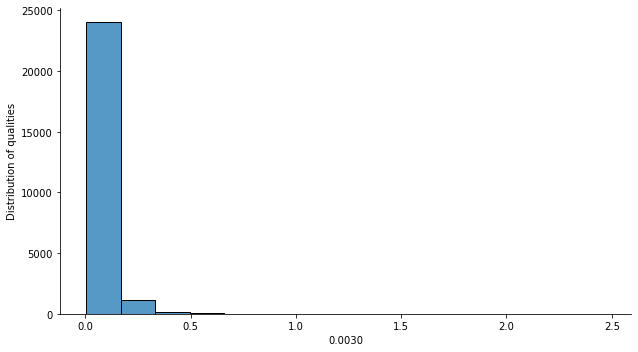

In [3]:
# Import the necessary modules
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize the lists for X and Y
data = pd.read_csv('trnL_sub.qual', sep='\t')

df = pd.DataFrame(data)

# distribution based on column 2 from file
dist_plot = sns.displot(df.iloc[:, 1], bins=15)

# show plot with custom width
dist_plot.fig.set_figwidth(10)
plt.ylabel("Distribution of qualities")

As expected, we have **very low error rates**, that's **pretty good!**

Now, let's check our **read cleaning processing**:

First, take a look again in the tag-pair found in **lowercase** in the demultiplexed sequences:

In [4]:
!head -2 demulti_linked_samples/Angelicaesinensis_a_LA.fq

@M02980:420:000000000-G84WN:1:1101:14746:1924 1:N:0:GTCTACAC+GCCAAGGT
caccttaccttaCCATTGAGTCTCTGCACCTATCCCCTTCCTATCTTAGGAGAAGAAACATTGTCTTCATGAACCGGATTTGGCTCAGGATTGCCCcctatgtgatgg


Let's chack again the tag-pair for **Angelicaesinensis_a** sample:

In [5]:
!grep "Angelicaesinensis_a" trnL_sub_tags.txt

Angelicaesinensis_a	CACCTTACCTTA	CCATCACATAGG


Now, take a look in the **clip_out/tag_clip** output sequences:

In [ ]:
!head -2 clip_out/tag_clip/Angelicaesinensis_a_trim1.fq

<p>As you can see in the mapping file, the 5&apos; tag is in forward direction <strong>caccttacctta</strong>, and the 3&apos; tag is the reverse complement of the reverse tag <strong>cctatgtgatgg&nbsp;</strong>(prom R2 pair-end read), configuring the tags orientation found in the <strong>Barcodes_LA3.fa</strong> file, which is the most common tag orientation in <strong>merged Illumina paired-end reads</strong>.</p>
<p>Right after the tags in lowercase, we can see the the <strong>3&apos; primer in forward direction</strong> CCATTGAGTCTCTGCACCTATC, the <strong>amplicon </strong>and the <strong>5&apos; primer in reverse direction</strong>.</p>

caccttacctta**CCATTGAGTCTCTGCACCTATC**`CCCTTCCTATCTTAGGAGAAGAAACATTGTCTTCATGAACCGGAT`**TTGGCTCAGGATTGCCC**cctatgtgatgg

This amplicon is **3'->5'** oriented.<p>
In the **`5'`** we find the `Reverse primer`, and in the **`3'`** we find the `Forward primer`, reverse complement.

Observe now in the **primer_clip** output the **primer removal**:

In [6]:
!head -2 clip_out/primer_clip/Angelicaesinensis_a_trim2.fq

@M02980:420:000000000-G84WN:1:1101:14746:1924 1:N:0:GTCTACAC+GCCAAGGT
CCCTTCCTATCTTAGGAGAAGAAACATTGTCTTCATGAACCGGAT


And finally, the **dereplicated** samples' sequences:

In [7]:
!head -2 dereplicated/Angelicaesinensis_a_dp.fasta

>addff39eca064dd9caa294721e6a23cab9c331ab;size=11061
ATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAG


In the **dereplicated** samples, we have our **trimmed**, clean amplicons, with proper **hash names** and **abundance** "size" information.

**How many sequences were lost during the read cleaning step?**

First, let's **count** the amount of **reads** for each **sample** right after the demultiplexing step:

In [8]:
%%bash
./count_fastq_sequences.sh demulti_linked_samples/*.fq > demulti_count_trnL.txt

In [9]:
!head demulti_count_trnL.txt

	demulti_linked_samples/Angelicaesinensis_a_LA.fq : 22,358
	demulti_linked_samples/Angelicaesinensis_b_LA.fq : 31,246
	demulti_linked_samples/Carthamustinctorius_a_LA.fq : 29,172
	demulti_linked_samples/Carthamustinctorius_b_LA.fq : 11,424
	demulti_linked_samples/Citrusaurantium_a_LA.fq : 2,876
	demulti_linked_samples/Citrusaurantium_b_LA.fq : 56,024
	demulti_linked_samples/Cyperusrotundus_a_LA.fq : 32,552
	demulti_linked_samples/Cyperusrotundus_b_LA.fq : 2,299
	demulti_linked_samples/GXZYT_a_LA.fq : 37,335
	demulti_linked_samples/GXZYT_b_LA.fq : 2,810


**We are ready to run the clustering step, which groups the amplicons by nucleotide similarity, creating the OTUs `(Operational Taxonomic Units)`, called by different names all the time. Basically, clustered similar amplicons.**

In [11]:
%%bash
./4_clustering_swarm_with_chim_filter.sh trnL_sub /home/jupyter/METAPIPE_Workshop2021/dereplicated

vsearch v2.18.0_linux_x86_64, 14.7GB RAM, 4 cores
https://github.com/torognes/vsearch

Dereplicating file ./tmp.iZ1ST0tzDu 100%
2042036 nt in 34521 seqs, min 32, max 218, avg 59
Sorting 100%
25373 unique sequences, avg cluster 25.4, median 1, max 44856
Writing output file 100%
Swarm 3.0.0
Copyright (C) 2012-2019 Torbjorn Rognes and Frederic Mahe
https://github.com/torognes/swarm

Mahe F, Rognes T, Quince C, de Vargas C, Dunthorn M (2014)
Swarm: robust and fast clustering method for amplicon-based studies
PeerJ 2:e593 https://doi.org/10.7717/peerj.593

Mahe F, Rognes T, Quince C, de Vargas C, Dunthorn M (2015)
Swarm v2: highly-scalable and high-resolution amplicon clustering
PeerJ 3:e1420 https://doi.org/10.7717/peerj.1420

CPU features:      mmx sse sse2 sse3 ssse3 sse4.1 sse4.2 popcnt avx avx2
Database file:     -
Output file:       trnL_sub_cluster_tmp.swarms
Statistics file:   trnL_sub_cluster_tmp.stats
Resolution (d):    1
Threads:           8
Break OTUs:        Yes
Fastidious:    

You may check SWARM documentation here: https://github.com/torognes/swarm

**Let's check what was produced?**

In [12]:
%ls -lat | head

total 2554072
drwxr-xr-x  8 jupyter jupyter      12288 Dec 14 00:12 ./
drwxr-xr-x  2 jupyter jupyter       4096 Dec 14 00:12 chimera_out/
-rw-r--r--  1 jupyter jupyter     435371 Dec 14 00:12 trnL_sub_cluster_representatives.uchime
-rw-r--r--  1 jupyter jupyter    1220308 Dec 14 00:12 trnL_sub_cluster.swarms
-rw-r--r--  1 jupyter jupyter     202860 Dec 14 00:12 trnL_sub_cluster.stats
-rw-r--r--  1 jupyter jupyter     410257 Dec 14 00:12 trnL_sub_cluster_representatives2blast.fas
-rw-r--r--  1 jupyter jupyter     433105 Dec 14 00:12 trnL_sub_cluster_representatives.fas
-rw-r--r--  1 jupyter jupyter    2786227 Dec 14 00:12 trnL_sub_global_dp.fas
drwxr-xr-x  8 jupyter jupyter       4096 Dec 14 00:11 .git/


The `_representatives.fas` presents the representative sequence of each OTU, in fasta format, and respective OTU abundance.

In [13]:
!head -4 trnL_sub_cluster_representatives.fas

>a84c749701d67d1226018c6714b72e543a618f16;size=64940;
CTTTTTTTATATAAAAAAAAATTTTATAATATAATAAAAAATTTAGAATAATAATATTCTATATATATTATATATTTTTTTATATTTTTTCAAAATAATGAT
>ac90db76fbae68003ec939d36b9847a46cbfa3c7;size=51129;
ATCCTCTTCTCTTTTCCAAGAACAAACAGGGGTTCAGAAAGCGAAAAAGGGG


The `_representatives2blast.fas` is the same output as `_representatives.fas`, but the abundance information is edited in order to facilitate the Blast header parsing.

In [14]:
!head -4 trnL_sub_cluster_representatives2blast.fas

>a84c749701d67d1226018c6714b72e543a618f16_64940
CTTTTTTTATATAAAAAAAAATTTTATAATATAATAAAAAATTTAGAATAATAATATTCTATATATATTATATATTTTTTTATATTTTTTCAAAATAATGAT
>ac90db76fbae68003ec939d36b9847a46cbfa3c7_51129
ATCCTCTTCTCTTTTCCAAGAACAAACAGGGGTTCAGAAAGCGAAAAAGGGG


The `.stats` output is very important, because it holds the **quantitative metrics** for each OTU:<p>

In [19]:
!head -4 trnL_sub_cluster.stats

2684	64940	a84c749701d67d1226018c6714b72e543a618f16	44856	1949	8	8
989	51129	ac90db76fbae68003ec939d36b9847a46cbfa3c7	43740	730	5	5
865	43673	2987db85c9fae5a1464f814e070b7507621e8a57	36626	635	4	4
767	37670	a069993ab97b3f720cf66567bfb1fad838b20dc6	32359	553	5	5


1.number of unique sequences in the OTU,<p>
2.**total abundance of sequences in the OTU**,<p>
3.**identifier of the initial seed (the amplicon)**,<p>
4.initial seed abundance,<p>
5.number of sequences with an abundance of 1 in the OTU (singletons),<p>
6.maximum number of iterations before the OTU reached its natural limit,<p>
7.cummulated number of steps along the path joining the seed and the furthermost amplicon in the OTU.<p>

The `.uchime` output shows the chimera checking metrics:

In [20]:
get_glimpse_head('trnL_sub_cluster_representatives.uchime', file_header=False, n_lines=4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,a84c749701d67d1226018c6714b72e543a618f16;size=...,*,*,*,*,*,*,*,*,0,0,0,0,0,0,*,N
1,0.0,ac90db76fbae68003ec939d36b9847a46cbfa3c7;size=...,*,*,*,*,*,*,*,*,0,0,0,0,0,0,*,N
2,0.0,2987db85c9fae5a1464f814e070b7507621e8a57;size=...,*,*,*,*,*,*,*,*,0,0,0,0,0,0,*,N
3,0.0,addff39eca064dd9caa294721e6a23cab9c331ab;size=...,*,*,*,*,*,*,*,*,0,0,0,0,0,0,*,N


... which in this case are all *non-chimeras*:

In [21]:
!grep -c "T" trnL_sub_cluster_representatives.uchime 

0


**Now we are ready to perform the BLAST alignment of the representative seeds `(OTU representatives)` against our reference database previously formatted:**

We are going to run the following steps using the **complete `Streptophyta_trnL_NCBI.fasta` database** previously downloaded, and the respective **`target_trnL.uniq.fasta`** fasta with the formatted **taxonomy lineage** headers.

In [22]:
!bash 5_BLAST_options.sh -h

##################################################
BLAST alignment against custom or NCBI NT local database.
 
Usage: 5_BLAST_options.sh [-f fasta] [-d database] [-s float] [-c float] [-t treads] [-o output]
-f     representative OTUs multifasta from clustering step
-d     database to align against: 'NT' or 'My_refs.uniq.fasta'
-s     minimum similarity between query and subject, float 0-1
-c     minimum subject coverage reached by the query alignment, float 0-1
-t     number of threads:
           custom database: 2 threads for each 1000 seqs.
           NCBI NT database: 4 threads for each 1000 seqs.
-o     output name: 'name'_local_blast.tab
-h     print this help
 
##################################################


In [23]:
%%bash
./5_BLAST_options.sh \
    -f trnL_sub_cluster_representatives2blast.fas \
    -d target_trnL.uniq.fasta -s 0.95 -c 0.5 -t 4 -o target95_trnL



Building a new DB, current time: 12/14/2021 00:14:31
New DB name:   /home/jupyter/METAPIPE_Workshop2021/target_trnL.uniq.fasta
New DB title:  target_trnL.uniq.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 15359 sequences in 0.529497 seconds.




./5_BLAST_options.sh: 59: [: target_trnL.uniq.fasta: unexpected operator
./5_BLAST_options.sh: 59: [: target_trnL.uniq.fasta: unexpected operator


ATTENTION: if you would like to run the search against the entire `NT` NCBI database, run The BLAST command above using `-d NT`.

In [24]:
%ls -lat | head

total 2560740
drwxr-xr-x  8 jupyter jupyter      12288 Dec 14 00:14 ./
-rw-r--r--  1 jupyter jupyter      99741 Dec 14 00:14 target95_trnL_OTU_tax_assignments.txt
-rw-r--r--  1 jupyter jupyter     118761 Dec 14 00:14 Blast_results_formatted2OTUtable.tab
-rw-r--r--  1 jupyter jupyter     121934 Dec 14 00:14 target95_trnL_local_blast.tab
-rw-r--r--  1 jupyter jupyter     749568 Dec 14 00:14 target_trnL.uniq.fasta.ndb
-rw-r--r--  1 jupyter jupyter     291829 Dec 14 00:14 target_trnL.uniq.fasta.nos
-rw-r--r--  1 jupyter jupyter      16384 Dec 14 00:14 target_trnL.uniq.fasta.ntf
-rw-r--r--  1 jupyter jupyter     184316 Dec 14 00:14 target_trnL.uniq.fasta.not
-rw-r--r--  1 jupyter jupyter      61440 Dec 14 00:14 target_trnL.uniq.fasta.nto


**Let's get a glimpse of the BLAST result?**

In [25]:
get_glimpse_head('target95_trnL_local_blast.tab', file_header=False)

,0,1,2,3,4
0,ac90db76fbae68003ec939d36b9847a46cbfa3c7_51129,100.0,Eukaryota|Streptophyta|Magnoliopsida|Sapindale...,gb|KY656130.1|,NaN
1,2987db85c9fae5a1464f814e070b7507621e8a57_43673,100.0,Eukaryota|Streptophyta|Magnoliopsida|Poales|Po...,gb|MN715130.1|,NaN
2,addff39eca064dd9caa294721e6a23cab9c331ab_41429,100.0,Eukaryota|Streptophyta|Magnoliopsida|Apiales|A...,gb|MT846883.1|,NaN
3,a069993ab97b3f720cf66567bfb1fad838b20dc6_37670,100.0,Eukaryota|Streptophyta|Magnoliopsida|Laurales|...,gb|MN482111.1|,NaN
4,28bf85082548d49c8d3b2793064a2fae0f417562_34741,100.0,Eukaryota|Streptophyta|Magnoliopsida|Rosales|R...,gb|MK411811.1|,NaN
5,967e951648145482fcc47f85b2a3530bec26d552_33003,100.0,Eukaryota|Streptophyta|Magnoliopsida|Apiales|A...,gb|MT846883.1|,NaN
6,36ecc3a6b7c304e724eb2680f97c751acaa0cdf6_20092,100.0,Eukaryota|Streptophyta|Magnoliopsida|Fabales|F...,gb|MN167287.1|,NaN
7,7bb64ef2725b146c74add357867e20995ecd52ee_19835,100.0,Eukaryota|Streptophyta|Magnoliopsida|Sapindale...,gb|KY656130.1|,NaN
8,1d2c40bd28ba9fcb65db0be2eea63b1e8e1428c4_17286,100.0,Eukaryota|Streptophyta|Magnoliopsida|Asterales...,gb|MW984537.1|,NaN
9,720f7ec10f985a208dcb0947d436ba0b5871ed40_16708,100.0,Eukaryota|Streptophyta|Magnoliopsida|Poales|Po...,gb|MN715130.1|,NaN


Now converting the abundance information into a column:

In [26]:
get_glimpse_head('Blast_results_formatted2OTUtable.tab', file_header=False)

,0,1,2,3,4,5
0,ac90db76fbae68003ec939d36b9847a46cbfa3c7,51129,100.0,Eukaryota|Streptophyta|Magnoliopsida|Sapindale...,KY656130.1,NaN
1,2987db85c9fae5a1464f814e070b7507621e8a57,43673,100.0,Eukaryota|Streptophyta|Magnoliopsida|Poales|Po...,MN715130.1,NaN
2,addff39eca064dd9caa294721e6a23cab9c331ab,41429,100.0,Eukaryota|Streptophyta|Magnoliopsida|Apiales|A...,MT846883.1,NaN
3,a069993ab97b3f720cf66567bfb1fad838b20dc6,37670,100.0,Eukaryota|Streptophyta|Magnoliopsida|Laurales|...,MN482111.1,NaN
4,28bf85082548d49c8d3b2793064a2fae0f417562,34741,100.0,Eukaryota|Streptophyta|Magnoliopsida|Rosales|R...,MK411811.1,NaN
5,967e951648145482fcc47f85b2a3530bec26d552,33003,100.0,Eukaryota|Streptophyta|Magnoliopsida|Apiales|A...,MT846883.1,NaN
6,36ecc3a6b7c304e724eb2680f97c751acaa0cdf6,20092,100.0,Eukaryota|Streptophyta|Magnoliopsida|Fabales|F...,MN167287.1,NaN
7,7bb64ef2725b146c74add357867e20995ecd52ee,19835,100.0,Eukaryota|Streptophyta|Magnoliopsida|Sapindale...,KY656130.1,NaN
8,1d2c40bd28ba9fcb65db0be2eea63b1e8e1428c4,17286,100.0,Eukaryota|Streptophyta|Magnoliopsida|Asterales...,MW984537.1,NaN
9,720f7ec10f985a208dcb0947d436ba0b5871ed40,16708,100.0,Eukaryota|Streptophyta|Magnoliopsida|Poales|Po...,MN715130.1,NaN


And finally formatting the BLAST output as the **taxa assignment table**, required to run the **data analysis** process using R packages, mostly the **Phyloseq** package: 

In [27]:
get_glimpse_head('target95_trnL_OTU_tax_assignments.txt', file_header=True)

,amplicon,Kingdom,Phylum,Class,Ord,Family,Genus,Species,SIM,OTU_abundance
0,ac90db76fbae68003ec939d36b9847a46cbfa3c7,Eukaryota,Streptophyta,Magnoliopsida,Sapindales,Rutaceae,Citrus,micrantha,100.0,51129
1,2987db85c9fae5a1464f814e070b7507621e8a57,Eukaryota,Streptophyta,Magnoliopsida,Poales,Poaceae,Zea,mays,100.0,43673
2,addff39eca064dd9caa294721e6a23cab9c331ab,Eukaryota,Streptophyta,Magnoliopsida,Apiales,Apiaceae,Selinum,carvifolia,100.0,41429
3,a069993ab97b3f720cf66567bfb1fad838b20dc6,Eukaryota,Streptophyta,Magnoliopsida,Laurales,Lauraceae,Cinnamomum,camphora,100.0,37670
4,28bf85082548d49c8d3b2793064a2fae0f417562,Eukaryota,Streptophyta,Magnoliopsida,Rosales,Rosaceae,Prunus,sunhangii,100.0,34741
5,967e951648145482fcc47f85b2a3530bec26d552,Eukaryota,Streptophyta,Magnoliopsida,Apiales,Apiaceae,Selinum,carvifolia,100.0,33003
6,36ecc3a6b7c304e724eb2680f97c751acaa0cdf6,Eukaryota,Streptophyta,Magnoliopsida,Fabales,Fabaceae,Glycyrrhiza,glabra,100.0,20092
7,7bb64ef2725b146c74add357867e20995ecd52ee,Eukaryota,Streptophyta,Magnoliopsida,Sapindales,Rutaceae,Citrus,micrantha,100.0,19835
8,1d2c40bd28ba9fcb65db0be2eea63b1e8e1428c4,Eukaryota,Streptophyta,Magnoliopsida,Asterales,Asteraceae,NaN,sp.,100.0,17286
9,720f7ec10f985a208dcb0947d436ba0b5871ed40,Eukaryota,Streptophyta,Magnoliopsida,Poales,Poaceae,Zea,mays,100.0,16708


We can get some interesting information right here, with out **taxa assignment table**:

**Let's check the distribuition reads per Family?**

Text(3.674999999999997, 0.5, 'Number of reads')

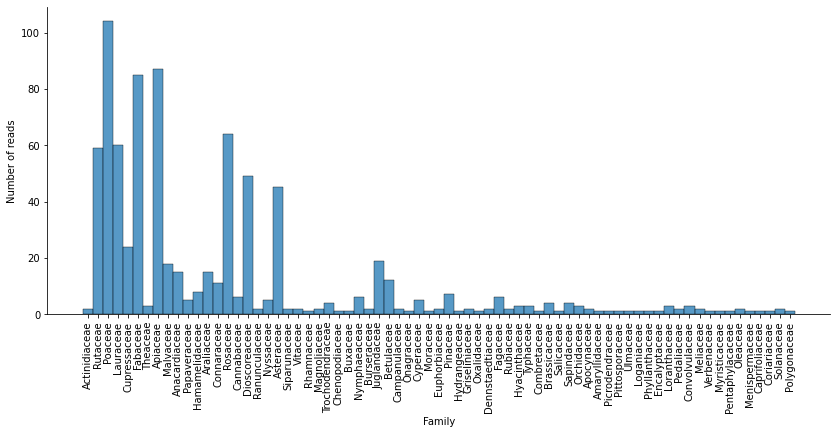

In [28]:
# Import the necessary modules
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize the lists for X and Y
data = pd.read_csv('target95_trnL_OTU_tax_assignments.txt', sep='\t')

df = pd.DataFrame(data).sort_values('OTU_abundance')

# distribution (histogram) based on column 2 from file
dist_plot = sns.displot(df['Family'], bins=15)

# show plot with custom width
dist_plot.fig.set_figwidth(14)
plt.xticks(rotation='vertical')
plt.ylabel("Number of reads")

Without doing any data analysis, we already know that our most abundant Families are **`Poaceae`**, **`Apiaceae`**, and **`Fabaceae`**, respectively.

**How about the total count of OTUs by Family?**<p>
The count of distinct OTUs found within a taxa rank is considered one of the alpha-diversity/richness metrics.

<AxesSubplot:xlabel='Family', ylabel='Total OTU count'>

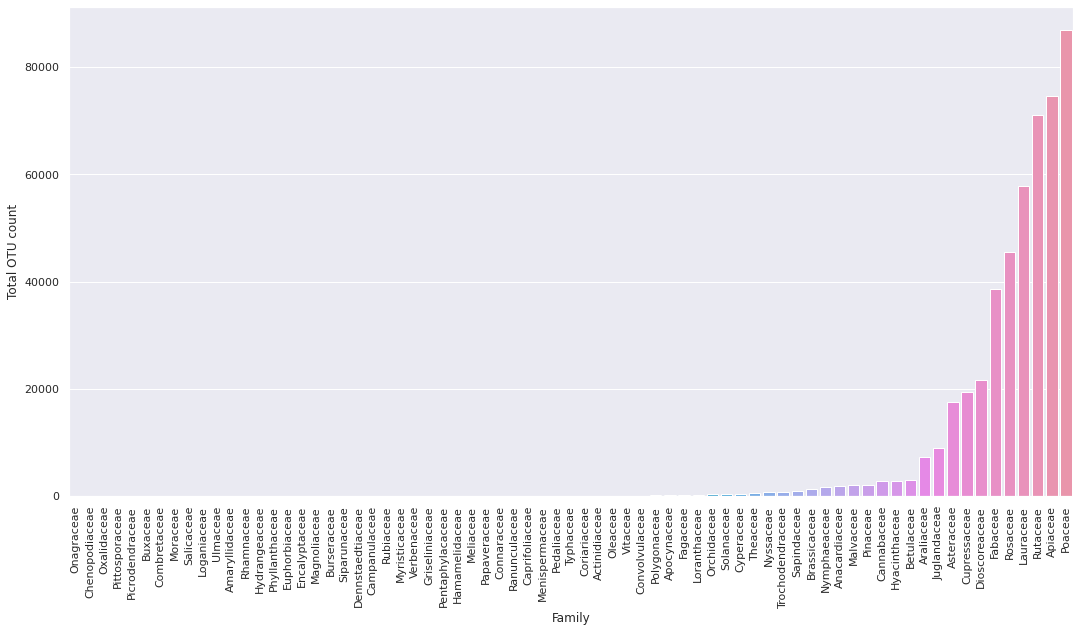

In [30]:
# Import the necessary modules
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Initialize the lists for X and Y
data = pd.read_csv('target95_trnL_OTU_tax_assignments.txt', sep='\t')

df = pd.DataFrame(data).sort_values('Family').groupby(['Family'])

otus_by_family = df['OTU_abundance'].agg([np.sum]).reset_index().sort_values('sum')

# distribution (histogram) based on column 2 from file
bar_plot = sns.barplot(x='Family', y='sum', data=otus_by_family)

# show plot with custom width
sns.set(rc={'figure.figsize':(20,10)})
plt.xticks(rotation='vertical')
plt.ylabel("Total OTU count")
bar_plot

Now we know that **`Poaceae`** and **`Apiaceae`** are the most abundant and present also the higher richness of OTUs. The amount of distinct OTUs observed for **`Fabaceae`** Family indicates that, besides having higher abundance, it is not directly related to richness.

**The final step of METAPIPE is the OTU table building.**<p>
Let's check the **required inputs**:<p>
`trnL_sub_cluster_representatives.fas` > the amplicon identification (seed),<p>
`trnL_sub_cluster.stats` > the quantitative metrics, as the OTU abundance,<p> 
`trnL_sub_cluster.swarms` > the distribution of the `amplicon/seeds/OTU` throughout the samples,<p>
`trnL_sub_cluster_representatives.uchime` > the identification of chimeras,<p>
`trnL_sub.qual` > the error rate and read length information,<p>
`Blast_results_formatted2OTUtable.tab` > the taxonomic assignment and lineage,<p>
`/home/jupyter/METAPIPE_Workshop2021/dereplicated` > all the sequences per sample.<p>

In [31]:
 %%bash
./6a_build_OTU_table.sh \
    trnL_sub_cluster_representatives.fas \
    trnL_sub.qual \
    Blast_results_formatted2OTUtable.tab \
    /home/jupyter/METAPIPE_Workshop2021/dereplicated

In [32]:
%ls -t | head

trnL_sub_cluster_OTU_table_complete.tab
metapipe-run.ipynb
target95_trnL_OTU_tax_assignments.txt
Blast_results_formatted2OTUtable.tab
target95_trnL_local_blast.tab
target_trnL.uniq.fasta.ndb
target_trnL.uniq.fasta.nos
target_trnL.uniq.fasta.ntf
target_trnL.uniq.fasta.not
target_trnL.uniq.fasta.nto


In [33]:
get_glimpse_head('trnL_sub_cluster_OTU_table_complete.tab', file_header=True)

,OTU,total,cloud,amplicon,length,abundance,chimera,spread,quality,sequence,...,Paeonialactiflora_a_dp,Paeonialactiflora_b_dp,Peoniasuffruticosa_a_dp,Peoniasuffruticosa_b_dp,Poriacocos_a_dp,Poriacocos_b_dp,Prunuspersica_a_dp,Prunuspersica_b_dp,Trogopterusxanthipes_a_dp,Trogopterusxanthipes_b_dp
0,1,64940,2684,a84c749701d67d1226018c6714b72e543a618f16,102,44856,N,12,0.0001,CTTTTTTTATATAAAAAAAAATTTTATAATATAATAAAAAATTTAG...,...,0,0,0,0,0,0,0,2,30,41198
1,2,51129,989,ac90db76fbae68003ec939d36b9847a46cbfa3c7,52,43740,N,25,0.0001,ATCCTCTTCTCTTTTCCAAGAACAAACAGGGGTTCAGAAAGCGAAA...,...,2,8,0,0,2,2,4,32,580,2
2,3,43673,865,2987db85c9fae5a1464f814e070b7507621e8a57,51,36626,N,22,0.0001,ATCCCTTTTTTGAAAAACAAGTGGTTCTCAAACTAGAACCCAAAGG...,...,6,0,6,0,0,0,2,6,90,4
3,4,41429,1607,addff39eca064dd9caa294721e6a23cab9c331ab,45,31239,N,33,0.0001,ATCCTATTTTCCAAAAACAAACAAAGGCCCAGAAGGTGAAAAAAG,...,46,130,8,10,54,6,12,406,194,16
4,5,37670,767,a069993ab97b3f720cf66567bfb1fad838b20dc6,53,32359,N,11,0.0001,ATCCTGTTTTCAGAAAACAAGGGTTCAGAAAGCGAGAACCAAAAAA...,...,0,0,0,0,8,0,0,10,2,0
5,6,34741,585,28bf85082548d49c8d3b2793064a2fae0f417562,51,30199,N,32,0.0001,ATCCTGTTTTATTAAAACAAACAAGGGTTTCATAAACCGAGAATAA...,...,206,64,82,66,64,18,19908,24204,128,2
6,7,33003,886,967e951648145482fcc47f85b2a3530bec26d552,45,26122,N,29,0.0001,CTTTTTTCACCTTCTGGGCCTTTGTTTGTTTTTGGAAAATAGGAT,...,0,24,8220,140,4,22,20,532,4,210
7,8,32635,669,8cdbd592419bf9c65aa2691a6c163fe4c16042bb,52,27813,N,33,0.0001,ATCCTGTTTTCCGAAAACAAACACAAAGATTCAGAAAGCAAGAATA...,...,950,15818,24934,1024,120,42,290,36,80,18
8,9,21016,498,9cb16aaf5f7887b597ac5fc1bba7e95e881b0d3c,52,17905,N,30,0.0001,CTTTTTTATTCTTGCTTTCTGAATCTTTGTGTTTGTTTTCGGAAAA...,...,52,80,156,26,146,140,3220,82,5174,2
9,10,20092,428,36ecc3a6b7c304e724eb2680f97c751acaa0cdf6,51,17460,N,31,0.0001,ATCCTGCTTTCCGAAAACAAAGAAAAGTTCAGAAAGCGAGAATAAA...,...,180,36,14,4,4,14,14,156,4,4


Take a look on each column meaning:<p>
**OTU** > each OTU gets a number,<p>
**total** > total number of reads in the OTU (OTU abundance),<p>
**cloud** > total number of unique sequences in the OTU,<p>
**amplicon** > identifier of the OTU/seed representative,<p>
**length** > length of the OTU representative,<p>
**abundance** > abundance of the OTU representative (not the OTU cluster),<p>
**chimera** > is it a chimera? Yes, No, ?,<p>
**spread** > number of samples where the OTU occurs (important for ecological filterings),<p>
**quality** > minimum expected error observed for the OTU representative, divided by sequence length,<p>
**sequence** > sequence of the OTU representative (amplicon),<p>
**identity** > BLAST similarity of the OTU representative with reference sequences,<p>
**taxonomy** > taxonomic assignment of the OTU representative (lineage),<p>
**samples** > each sample as a column, with respective reads abundance.

The **OTU table** originally generated has **all information possible**, allowing for searches and queries within it.<p>
To load the OTU table in R, we need to filter the complete table, in order to have only the **4.amplicon** column, and all the **samples** columns.<p>
We can do this by only selecting the above mentioned columns, using a command like this:<p>
`cat trnL_sub_cluster_OTU_table_complete.tab | cut -f 4,14- > trnL_sub_cluster_OTU_table_cut2phyloseq2.tab`<p>

In [34]:
cat trnL_sub_cluster_OTU_table_complete.tab | cut -f 4,14- | head -4

amplicon	*_dp	Angelicaesinensis_a_dp	Angelicaesinensis_b_dp	Carthamustinctorius_a_dp	Carthamustinctorius_b_dp	Citrusaurantium_a_dp	Citrusaurantium_b_dp	Cyperusrotundus_a_dp	Cyperusrotundus_b_dp	GXZYT_a_dp	GXZYT_b_dp	GZFLW_a_dp	GZFLW_b_dp	Glycyrrhizauralensis_a_dp	Glycyrrhizauralensis_b_dp	GuiZhiFuLingPian_a_dp	GuiZhiFuLingPian_b_dp	GuiZhiFuLingTan_a_dp	GuiZhiFuLingTan_b_dp	Ligusticumchuanxiong_a_dp	Ligusticumchuanxiong_b_dp	Linderaaggregata_a_dp	Linderaaggregata_b_dp	NegativePCR_dp	Negative_dp	Paeonialactiflora_a_dp	Paeonialactiflora_b_dp	Peoniasuffruticosa_a_dp	Peoniasuffruticosa_b_dp	Poriacocos_a_dp	Poriacocos_b_dp	Prunuspersica_a_dp	Prunuspersica_b_dp	Trogopterusxanthipes_a_dp	Trogopterusxanthipes_b_dp
a84c749701d67d1226018c6714b72e543a618f16	0	0	37102	51274	24	0	14	0	0	0	0	0	24	26	132	0	0	46	0	0	8	0	0	0	0	0	0	0	0	0	0	0	2	30	41198
ac90db76fbae68003ec939d36b9847a46cbfa3c7	0	0	0	2	58	342	98850	64	274	1656	26	0	0	8	0	38	16	4	20	12	2	0	0	12	242	2	8	0	0	2	2	4	32	580	2
2987db85c9fae5a1464

Or starting the Data Analysis preprocessing, by choosing some important thresholds, like:<p>
`awk -F "\t" '{ if(($7 == "N") && ($2 >= 2)) { print } }'` > which select only *non-chimeras* and OTUs with at least 2 reads (excluding singletons).<p>
or even more complex thresholds, like:<p>
`awk -F "\t" '{ if(($7 == "N") && ($2 >= 5) && ($9<=0.0002) && ($11 >= 97)) { print } }'` > which is selecting *non-chimeras*, OTUs with at least 5 reads, error rate lower than 0.0002 and taxonomic assignment similarity equal or higher than 97.<p>
**The following command does 4 preprocessing OTU table filtering and formatting to be load in R:**<p>

In [35]:
%%bash 
./6b_filter_OTU_table.sh \
    trnL_sub_cluster_OTU_table_complete.tab \
    trnL_sub.qual

In [36]:
%ls -t | head -20

trnL_sub.ee
trnL_sub_cluster_OTU_table_f4_no_hit2.tab
trnL_sub_cluster_OTU_table_f4_no_hit2_cut2phyloseq2.tab
trnL_sub_cluster_OTU_table_f3_hits_only2_cut2phyloseq2.tab
trnL_sub_cluster_OTU_table_f3_hits_only2.tab
trnL_sub_cluster_OTU_table_f2_97up2_cut2phyloseq2.tab
trnL_sub_cluster_OTU_table_f2_97up2.tab
trnL_sub_cluster_OTU_table_f1_basics2.tab
trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab
trnL_sub_cluster_OTU_table_complete.tab
metapipe-run.ipynb
target95_trnL_OTU_tax_assignments.txt
Blast_results_formatted2OTUtable.tab
target95_trnL_local_blast.tab
target_trnL.uniq.fasta.ndb
target_trnL.uniq.fasta.nos
target_trnL.uniq.fasta.ntf
target_trnL.uniq.fasta.not
target_trnL.uniq.fasta.nto
target_trnL.uniq.fasta.nog


Let's take a look in the **`most basic`** **OTU table**, formatted to be loaded in **Phyloseq**:

In [37]:
get_glimpse_head('trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab')

,amplicon,*,Angelicaesinensis_a,Angelicaesinensis_b,Carthamustinctorius_a,Carthamustinctorius_b,Citrusaurantium_a,Citrusaurantium_b,Cyperusrotundus_a,Cyperusrotundus_b,...,Paeonialactiflora_a,Paeonialactiflora_b,Peoniasuffruticosa_a,Peoniasuffruticosa_b,Poriacocos_a,Poriacocos_b,Prunuspersica_a,Prunuspersica_b,Trogopterusxanthipes_a,Trogopterusxanthipes_b
0,a84c749701d67d1226018c6714b72e543a618f16,0,0,37102,51274,24,0,14,0,0,...,0,0,0,0,0,0,0,2,30,41198
1,ac90db76fbae68003ec939d36b9847a46cbfa3c7,0,0,0,2,58,342,98850,64,274,...,2,8,0,0,2,2,4,32,580,2
2,2987db85c9fae5a1464f814e070b7507621e8a57,0,46,0,2,2,8,4,0,0,...,6,0,6,0,0,0,2,6,90,4
3,addff39eca064dd9caa294721e6a23cab9c331ab,0,37126,19230,10,12,6,124,72,8,...,46,130,8,10,54,6,12,406,194,16
4,a069993ab97b3f720cf66567bfb1fad838b20dc6,0,0,4,0,0,0,10,8960,30,...,0,0,0,0,8,0,0,10,2,0
5,28bf85082548d49c8d3b2793064a2fae0f417562,0,28,40,2,40,6,64,18,4,...,206,64,82,66,64,18,19908,24204,128,2
6,967e951648145482fcc47f85b2a3530bec26d552,0,588,8,6,46,42,658,4,24,...,0,24,8220,140,4,22,20,532,4,210
7,8cdbd592419bf9c65aa2691a6c163fe4c16042bb,0,10,22,8,54,14,82,812,2,...,950,15818,24934,1024,120,42,290,36,80,18
8,9cb16aaf5f7887b597ac5fc1bba7e95e881b0d3c,0,0,6,8,16,22,10,108,14,...,52,80,156,26,146,140,3220,82,5174,2
9,36ecc3a6b7c304e724eb2680f97c751acaa0cdf6,0,0,6,18,22,8,176,1938,2,...,180,36,14,4,4,14,14,156,4,4


**###################################################################################################################**<p>
**THE FOLLOWING COMMANDS ARE PART OF THE DATA ANALYSIS, WHICH WILL BE RUN USING THE THIRD NOTEBOOK `metapipe-r.ipynb`**<p>
**By running the Data Analysis steps using the R Notebook, `you will be redirected to this point, in this Notebook`.**<p>
**LET'S START THE DATA ANALYSIS, OPENING THE `metapipe-r.ipynb` Notebook!!!**
**###################################################################################################################**<p>

**Now that we have started our `data analysis` in `metapipe-r.ipynb` Notebook, we reached the point where we know which OTUs were amplified in the Negative control samples and we know which of those OTUs are the most abundant.**<p>
**Now we are going to explore `who` these Top abundance OTUs are:**

The following **`function`** is used to **`visualise`** the distribution of **`OTU abundance`** for each **`selected`** OTU:

In [ ]:
def plot_OTU_bars(amplicon, assignments, nbins, width):
    # Import the necessary modules
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import pandas as pd
    
    # import data
    data = pd.read_csv(assignments, sep='\t')
    
    # apply filter
    selection = pd.DataFrame(data).amplicon.str.contains(amplicon)
    df = data[selection].set_index('amplicon').T
    df.reset_index(inplace=True)
    
    # create barplot
    bar_plot = sns.barplot(x='index', y=str(amplicon), data=df)

    # show plot with custom width
    sns.set(rc={'figure.figsize':(width,9)})
    plt.xticks(rotation='vertical')
    plt.ylabel("Abundance")
    plt.xlabel("Sample")
    bar_plot

    # return results
    return bar_plot

**We know that in out negative sample `(data_neg subset)`, we have three Top OTUs:**<p>
265f74f49f9531de8808b253efa96dc7c320df27<p>
94385ff6f775ede0a8b76f5e4f3a9a0de58a4eca<p>
c65370ec20a9cdf9089e1983d7c5c3d4227a870<p>
**Let's check the Top3 OTUs from `data_neg` looking for `who` they are using our `OTU_tax_assignments.txt` table, and the OTU `abundance distribution` using our `OTU_table_f1_basics2_cut2phyloseq2.tab` table:**

In [ ]:
!grep "265f74f49f9531de8808b253efa96dc7c320df27" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "265f74f49f9531de8808b253efa96dc7c320df27", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**We observe that the Top1 OTU assigned as Juglandaceae *Juglans mandshuric* occurrs with high abundance in the `Negative` sample, but presents higher abundance in `Glycyrrhizauralensis_b` and `Paeonialactiflora_b` samples.**

Let's check the next Top OTU:

In [ ]:
!grep "94385ff6f775ede0a8b76f5e4f3a9a0de58a4eca" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "94385ff6f775ede0a8b76f5e4f3a9a0de58a4eca", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**Similarly, we observe that the Top2 OTU assigned to Dioscoreaceae *Dioscorea japonica* occurrs in the `Negative` sample, but presents much higher abundance in `Ligusticumchuanxiong_b` sample.**

In [ ]:
!grep "c65370ec20a9cdf9089e1983d7c5c3d4227a870b" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "c65370ec20a9cdf9089e1983d7c5c3d4227a870b", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**Again, we observe that the Top3 OTU amplified in the `Negative` control sample and also assigned to Dioscoreaceae *Dioscorea japonica* occurrs in relatively low abundance in the `Negative` sample, but presents much higher abundance in `GuiZhiFuLingTan_b` and `GXZYT_a` samples.**

**###################################################################################################################**<P>
**AT THIS POINT LET'S GO BACK TO `metapipe-r.ipynb` NOTEBOOK TO FIND OUT THE TOP OTUS FROM THE `NegativePCR` CONTROL SAMPLE!**<P>
**###################################################################################################################**

**Now that we have run the composition analysis of the `Negative PCR` control sample `(data_negPCR subset)`, we know that we have `TWO` Top OTUs to investigate:**<p>
**1ad23561fdff8989fd2e4e9a3735a4b8f5633fba**<p>
**250a541b1d3823011d21097b0f3880d831e6b92d**

**Let's check who these two OTUs amplified in the `Negative PCR` control sample are, and the respective OTU abundance distribution, as we did before:**

In [ ]:
!grep "1ad23561fdff8989fd2e4e9a3735a4b8f5633fba" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "1ad23561fdff8989fd2e4e9a3735a4b8f5633fba", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**We observe that the Top1 OTU from `data_negPCR subset`, assigned as Fabaceae *Euchresta horsfieldii*, occurrs with high abundance in the `NegativePCR` sample, but presents highest abundance in `Glycyrrhizauralensis_b` sample.**

Let's check the second most abundant OTU:

In [ ]:
!grep "250a541b1d3823011d21097b0f3880d831e6b92d" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "250a541b1d3823011d21097b0f3880d831e6b92d", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**We observe that the Top2 OTU from the `NegativePCR` control sample was assigned to Juglandaceae *Juglans mandshuric* (similarly to the Top1 OTU from `data_neg subset`), it occurrs in the `NegativePCR` sample in relatively low abundance, and presents the highest abundance in `GuiZhiFuLingTan_b` sample.**

**#############################################################################################################**<P>
**AT THIS POINT LET'S GO BACK TO `metapipe-r.ipynb` NOTEBOOK TO FIND OUT THE TOP OTUS FROM THE WHOLE DATASET!!!**<P>
**#############################################################################################################**

**Now that we know the `SIX` Top OTUs from the whole dataset, let's investigate who they are:**<p>
**ac90db76fbae68003ec939d36b9847a46cbfa3c7**<p>
**2987db85c9fae5a1464f814e070b7507621e8a57**<p>
**addff39eca064dd9caa294721e6a23cab9c331ab**<p>
**a069993ab97b3f720cf66567bfb1fad838b20dc6**<p>
**28bf85082548d49c8d3b2793064a2fae0f417562**<p>
**967e951648145482fcc47f85b2a3530bec26d552**

**We can observe already that the Top OTUs amplified in the `Negative` controls are not among the Top OTUs from the whole dataset, this is good.**

Let's check one by one again:

In [ ]:
!grep "ac90db76fbae68003ec939d36b9847a46cbfa3c7" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "ac90db76fbae68003ec939d36b9847a46cbfa3c7", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**We observe that the Top OTU assigned as Rutaceae *Citrus micrantha* is more abundant in `Citrusaurantium_b` sample.**

![Image of Prunus persica](https://i.pinimg.com/564x/63/03/e2/6303e2ca0575aac208367e3670599afd.jpg)

In [ ]:
!grep "2987db85c9fae5a1464f814e070b7507621e8a57" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "2987db85c9fae5a1464f814e070b7507621e8a57", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**We observe that the Top OTU assigned as Poaceae *Zea mays* is more abundant in `GZFLW_a` sample.**

![Image of Prunus persica](http://socorronacozinha.com.br/wp-content/uploads/2012/08/milho-cozido-manteiga-545x306.jpg)

In [ ]:
!grep "addff39eca064dd9caa294721e6a23cab9c331ab" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "addff39eca064dd9caa294721e6a23cab9c331ab", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**We observe that the Top OTU assigned as Apiaceae *Selinum carvifolia* is more abundant in `Angelicaesinensis_a/b`, and `GXZYT_a` samples.**

![Image of Prunus persica](https://alchetron.com/cdn/selinum-carvifolia-ba052cc2-9fff-4192-8f97-56186cb42d6-resize-750.jpeg)

In [ ]:
!grep "a069993ab97b3f720cf66567bfb1fad838b20dc6" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "a069993ab97b3f720cf66567bfb1fad838b20dc6", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**We observe that the top OTU assigned as Lauraceae *Cinnamomum camphora* is more abundant in `GuiZhiFuLingPian_a` and `Cyperusrotundus_a` samples.**

![Image of Prunus persica](https://jb.utad.pt/imagem/7614)

In [ ]:
!grep "28bf85082548d49c8d3b2793064a2fae0f417562" target95_trnL_OTU_tax_assignments.txt

In [ ]:
plot_OTU_bars(
    "28bf85082548d49c8d3b2793064a2fae0f417562", 
    "trnL_sub_cluster_OTU_table_f1_basics2_cut2phyloseq2.tab", 
    15,  # number of bins (bars)
    10)  # width

**We observe that the top OTU assigned as Rosaceae *Prunus sunhangii* is more abundant in `Prunuspersica_a/b`, `GXZYT_a` and `GZFLW_a` samples.**

![Image of Prunus persica](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/Nectarine_Fruit_Development.jpg/800px-Nectarine_Fruit_Development.jpg)

**It is a very good sign that we do not have any of the Top OTUs amplified in the `Negative` and `NegativePCR` samples among the general Top OTUs from the whole dataset.**

**#############################################################################################################**<P>
**AT THIS POINT LET'S GO BACK TO `metapipe-r.ipynb` NOTEBOOK TO RUN THE FOLLOWING DATA ANALYSIS**<p>
**#############################################################################################################**